In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
uhi_data = pd.read_csv('uhi_data_all.csv')

In [ ]:
uhi_data.head()

,Longitude,Latitude,UHI Index,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,NDVI,NDBI,NDWI,BVW
0,-77.302700,39.109905,0.993571,1427.0,1881.0,1936.0,1990.0,2280.0,2362.0,2450.0,2372.0,2561.0,2595.0,2349.0,0.087575,0.044896,-0.101207,-5.065499
1,-77.302690,39.109855,0.994674,1427.0,2250.0,2240.0,2344.0,2280.0,2362.0,2450.0,2792.0,2561.0,2595.0,2349.0,0.087227,-0.036570,-0.109698,3.821799
2,-77.302677,39.109960,0.993571,1427.0,1986.0,2092.0,2234.0,2133.0,2729.0,2979.0,2652.0,3158.0,2683.0,2227.0,0.085551,0.005811,-0.118044,-0.575388
3,-77.302630,39.110017,0.993571,1427.0,1907.0,2060.0,2084.0,2133.0,2729.0,2979.0,2528.0,3158.0,2683.0,2227.0,0.096271,0.029745,-0.102005,-3.028967
4,-77.302595,39.109767,0.993571,1427.0,1764.0,2000.0,1990.0,1963.0,2529.0,2921.0,2670.0,3050.0,2500.0,2082.0,0.145923,-0.032882,-0.143469,1.570643


Pearson correlation (NDVI): -0.3597


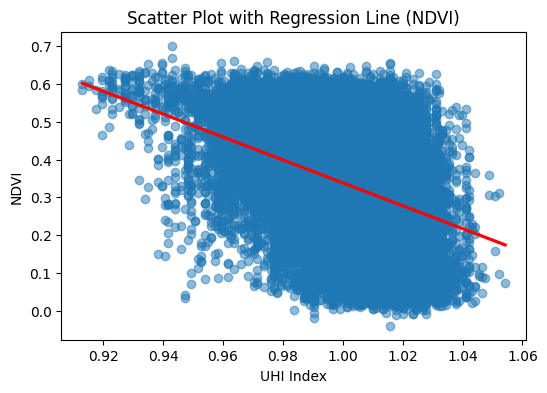

Pearson correlation (NDBI): 0.3129


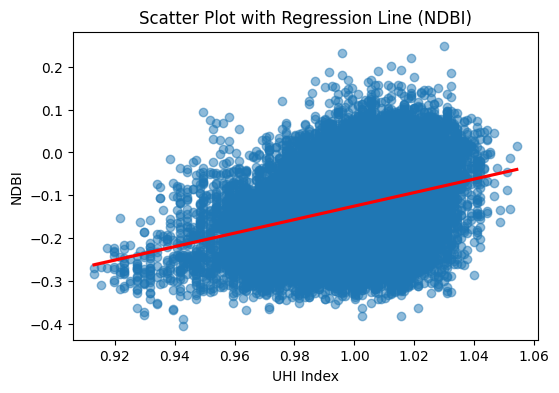

Pearson correlation (NDWI): 0.3582


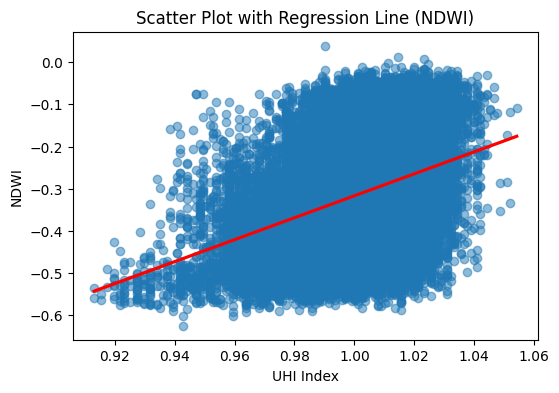

Pearson correlation (BVW): -0.0177


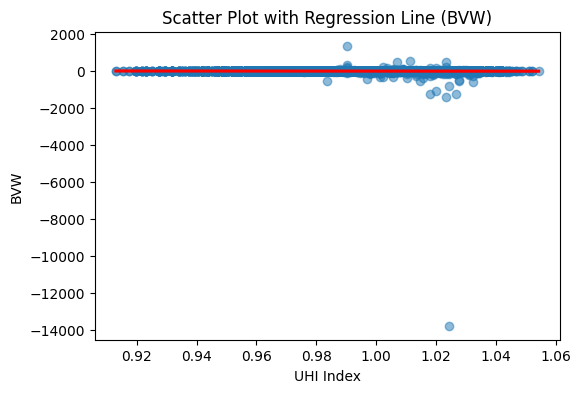

In [ ]:
features = ['NDVI', 'NDBI', 'NDWI', 'BVW']
corr = []
for i in range(len(features)):
    correlation = uhi_data['UHI Index'].corr(uhi_data[features[i]])
    corr.append(correlation)  
    print(f'Pearson correlation ({features[i]}): {correlation:.4f}')
    
    
    plt.figure(figsize=(6, 4))
    sns.regplot(x=uhi_data['UHI Index'], y=uhi_data[features[i]], 
                scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f"Scatter Plot with Regression Line ({features[i]})")
    plt.show()
    

In [ ]:
uhi_data = uhi_data[['B01', 'NDVI', 'NDBI', 'NDWI', 'UHI Index']]

X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

uhi_data = uhi_data[['B01', 'NDVI', 'NDBI', 'NDWI', 'UHI Index']]
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values

X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)

train_size = int(0.8 * len(X))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

# DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


class UHI_MLP(nn.Module):
    def __init__(self, input_dim):
        super(UHI_MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Batch Normalization
            nn.
            out(0.3),  # Dropout (Regularization)
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X.shape[1]
model = UHI_MLP(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(device))
    test_loss = criterion(test_predictions, y_test.to(device)).item()
    
print(f"Test MSE Loss: {test_loss:.4f}")

Using device: mps
Epoch 10/100, Loss: 0.0003
Epoch 20/100, Loss: 0.0003
Epoch 30/100, Loss: 0.0003
Epoch 40/100, Loss: 0.0003
Epoch 50/100, Loss: 0.0003
Epoch 60/100, Loss: 0.0003
Epoch 70/100, Loss: 0.0003
Epoch 80/100, Loss: 0.0003
Epoch 90/100, Loss: 0.0003
Epoch 100/100, Loss: 0.0003
Test MSE Loss: 0.0002


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import r2_score

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

uhi_data = uhi_data[['B01', 'NDVI', 'NDBI', 'NDWI', 'UHI Index']]
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values

X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)

train_size = int(0.8 * len(X))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class UHI_MLP(nn.Module):
    def __init__(self, input_dim):
        super(UHI_MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Batch Normalization
            nn.Dropout(0.3),  # Dropout (Regularization)
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X.shape[1]
model = UHI_MLP(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            train_predictions = model(X_train.to(device)).cpu().numpy()
            y_train_np = y_train.cpu().numpy()

            train_loss = criterion(torch.tensor(train_predictions), torch.tensor(y_train_np)).item()
            train_r2 = r2_score(y_train_np, train_predictions)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train MSE: {train_loss:.4f}, Train R²: {train_r2:.4f}")

model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    test_loss = criterion(torch.tensor(test_predictions), torch.tensor(y_test_np)).item()
    test_r2 = r2_score(y_test_np, test_predictions)

print(f"Final Test MSE Loss: {test_loss:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

Using device: mps
Epoch 10/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.0287
Epoch 20/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.0681
Epoch 30/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.2035
Epoch 40/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.1366
Epoch 50/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: -0.0045
Epoch 60/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: -0.0028
Epoch 70/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: -0.0035
Epoch 80/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: -0.0101
Epoch 90/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: -0.0080
Epoch 100/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: -0.0054
Final Test MSE Loss: 0.0002
Final Test R² Score: -0.2003


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

uhi_data = pd.read_csv('uhi_data_all.csv')
X = uhi_data.drop(columns=['UHI Index','Longitude','Latitude']).values
y = uhi_data['UHI Index'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

print(f"Original feature dimension: {X.shape[1]}")
print(f"Reduced feature dimension (PCA): {X_pca.shape[1]}")

X_tensor = torch.tensor(X_pca, dtype=torch.float32, device=device)
y_tensor = torch.tensor(y, dtype=torch.float32, device=device).view(-1, 1)

train_size = int(0.8 * len(X_pca))
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class UHI_MLP(nn.Module):
    def __init__(self, input_dim):
        super(UHI_MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),  # Batch Normalization
            nn.Dropout(0.3),  # Dropout (Regularization)
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_pca.shape[1]
model = UHI_MLP(input_dim).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            train_predictions = model(X_train.to(device)).cpu().numpy()
            y_train_np = y_train.cpu().numpy()

            train_loss = criterion(torch.tensor(train_predictions), torch.tensor(y_train_np)).item()
            train_r2 = r2_score(y_train_np, train_predictions)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train MSE: {train_loss:.4f}, Train R²: {train_r2:.4f}")

model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    test_loss = criterion(torch.tensor(test_predictions), torch.tensor(y_test_np)).item()
    test_r2 = r2_score(y_test_np, test_predictions)

print(f"Final Test MSE Loss: {test_loss:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

Using device: mps
Original feature dimension: 15
Reduced feature dimension (PCA): 5
Epoch 10/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.1462
Epoch 20/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.2156
Epoch 30/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.1108
Epoch 40/100, Loss: 0.0003, Train MSE: 0.0054, Train R²: -15.3213
Epoch 50/100, Loss: 0.0003, Train MSE: 0.0042, Train R²: -11.6722
Epoch 60/100, Loss: 0.0003, Train MSE: 0.0003, Train R²: 0.2002
Epoch 70/100, Loss: 0.0003, Train MSE: 0.0006, Train R²: -0.9009
Epoch 80/100, Loss: 0.0003, Train MSE: 0.0011, Train R²: -2.4366
Epoch 90/100, Loss: 0.0003, Train MSE: 0.0004, Train R²: -0.1116
Epoch 100/100, Loss: 0.0003, Train MSE: 0.0004, Train R²: -0.1851
Final Test MSE Loss: 0.0001
Final Test R² Score: 0.0475


In [ ]:
feature_names = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12", "NDVI", "NDBI", "NDWI", "BVW"]

pca_components = pd.DataFrame(pca.components_, columns=feature_names)

feature_importance_pca = np.abs(pca.components_).sum(axis=0)
feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance_pca})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print("Most impactful Features:")
print(feature_importance_df.head(5))

PCA에서 가장 영향을 많이 준 Feature들:
   Feature  Importance
12    NDBI    1.279860
0      B01    1.262991
14     BVW    1.174327
7      B08    1.114003
9      B11    1.058341


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importance_rf = rf.feature_importances_

feature_importance_df = pd.DataFrame({"Feature": feature_names, "Importance": feature_importance_rf})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

print("랜덤포레스트 Feature Importance:")
print(feature_importance_df.head(5))

랜덤포레스트 Feature Importance:
   Feature  Importance
0      B01    0.301173
4      B05    0.070092
10     B12    0.067109
8      B8A    0.065997
6      B07    0.063660


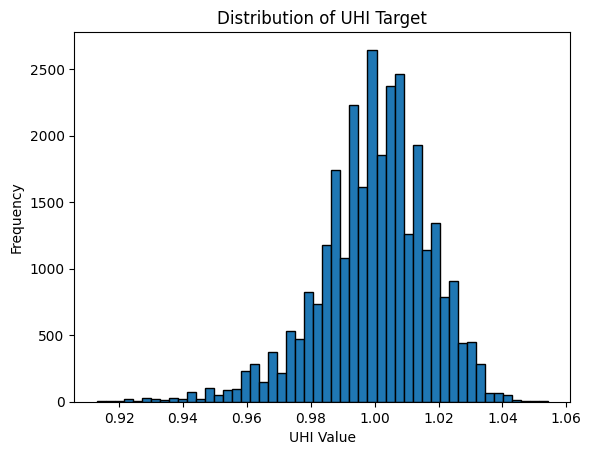

In [29]:
import matplotlib.pyplot as plt

plt.hist(y, bins=50, edgecolor='black')
plt.xlabel("UHI Value")
plt.ylabel("Frequency")
plt.title("Distribution of UHI Target")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F



device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

uhi_data = pd.read_csv('uhi_data_all.csv')
uhi_data = uhi_data[['UHI Index','B01', 'NDVI', 'NDBI', 'NDWI', 'BVW']]
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)

y_train = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device).view(-1, 1)


batch_size = 32
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class ResidualMLP(nn.Module):
    def __init__(self, input_dim):
        super(ResidualMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        
        self.shortcut = nn.Linear(input_dim, 32)


    def forward(self, x):
        residual = self.shortcut(x) 
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = x + residual
        return self.fc4(x)

input_dim = X.shape[1]
model = ResidualMLP(input_dim).to(device)

class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, y_pred, y_true):
        residual = torch.abs(y_true - y_pred)
        loss = torch.where(residual < self.delta, 0.5 * residual**2, self.delta * (residual - 0.5 * self.delta))
        return loss.mean()

criterion = HuberLoss(delta=1.0)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

epochs = 100

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    if (epoch+1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            train_predictions = model(X_train.to(device)).cpu().numpy()
            y_train_np = y_train.cpu().numpy()

            train_loss = criterion(torch.tensor(train_predictions), torch.tensor(y_train_np)).item()
            train_r2 = r2_score(y_train_np, train_predictions)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train MSE: {train_loss:.4f}, Train R²: {train_r2:.4f}")

model.eval()
with torch.no_grad():
    test_predictions = model(X_test.to(device)).cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    test_loss = criterion(torch.tensor(test_predictions), torch.tensor(y_test_np)).item()
    test_r2 = r2_score(y_test_np, test_predictions)

print(f"Final Test MSE Loss: {test_loss:.4f}")
print(f"Final Test R² Score: {test_r2:.4f}")

Using device: mps
Epoch 10/100, Loss: 0.0008, Train MSE: 0.0008, Train R²: -18.8471
Epoch 20/100, Loss: 0.0004, Train MSE: 0.0005, Train R²: -9.1975
Epoch 30/100, Loss: 0.0004, Train MSE: 0.0003, Train R²: -2.7173
Epoch 40/100, Loss: 0.0004, Train MSE: 0.0006, Train R²: -10.6112
Epoch 50/100, Loss: 0.0004, Train MSE: 0.0004, Train R²: -3.2819
Epoch 60/100, Loss: 0.0004, Train MSE: 0.0002, Train R²: -0.2198
Epoch 70/100, Loss: 0.0002, Train MSE: 0.0005, Train R²: -5.8585
Epoch 80/100, Loss: 0.0003, Train MSE: 0.0002, Train R²: -0.3597
Epoch 90/100, Loss: 0.0002, Train MSE: 0.0003, Train R²: -1.9396


KeyboardInterrupt: 

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

uhi_data = pd.read_csv('uhi_data_all.csv')
uhi_data = uhi_data[['UHI Index','B01', 'NDVI', 'NDBI', 'NDWI', 'BVW']]
X = uhi_data.drop(columns=['UHI Index']).values
y = uhi_data['UHI Index'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_data = xgb.DMatrix(X_train, label=y_train)
test_data = xgb.DMatrix(X_test, label=y_test)

def r2_metric(preds, dtrain):
    labels = dtrain.get_label()
    r2 = r2_score(labels, preds)
    return 'r2', r2

params = {
    'objective': 'reg:squarederror',
    'n_estimators': 200,
    'learning_rate': 0.01,
    'max_depth': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'tree_method': 'hist'
}

xgb_model = xgb.train(
    params,
    train_data,
    num_boost_round=200,
    evals=[(train_data, 'train'), (test_data, 'test')],
    feval=r2_metric,
    maximize=True,
    early_stopping_rounds=20
)

y_train_pred = xgb_model.predict(train_data)
y_test_pred = xgb_model.predict(test_data)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Train R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")

[0]	train-rmse:0.01718	train-r2:0.01095	test-rmse:0.01701	test-r2:0.00409
[1]	train-rmse:0.01709	train-r2:0.02127	test-rmse:0.01698	test-r2:0.00821
[2]	train-rmse:0.01699	train-r2:0.03179	test-rmse:0.01694	test-r2:0.01229
[3]	train-rmse:0.01691	train-r2:0.04190	test-rmse:0.01691	test-r2:0.01635
[4]	train-rmse:0.01682	train-r2:0.05199	test-rmse:0.01687	test-r2:0.02048


/Users/ibolam/miniforge3/envs/DL-torch310/lib/python3.10/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
/Users/ibolam/miniforge3/envs/DL-torch310/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:34:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[5]	train-rmse:0.01673	train-r2:0.06222	test-rmse:0.01684	test-r2:0.02432
[6]	train-rmse:0.01665	train-r2:0.07041	test-rmse:0.01682	test-r2:0.02655
[7]	train-rmse:0.01656	train-r2:0.08046	test-rmse:0.01679	test-r2:0.03006
[8]	train-rmse:0.01648	train-r2:0.09003	test-rmse:0.01676	test-r2:0.03387
[9]	train-rmse:0.01639	train-r2:0.09920	test-rmse:0.01673	test-r2:0.03748
[10]	train-rmse:0.01631	train-r2:0.10859	test-rmse:0.01670	test-r2:0.04102
[11]	train-rmse:0.01622	train-r2:0.11777	test-rmse:0.01667	test-r2:0.04451
[12]	train-rmse:0.01614	train-r2:0.12708	test-rmse:0.01664	test-r2:0.04775
[13]	train-rmse:0.01605	train-r2:0.13589	test-rmse:0.01661	test-r2:0.05085
[14]	train-rmse:0.01599	train-r2:0.14309	test-rmse:0.01660	test-r2:0.05257
[15]	train-rmse:0.01591	train-r2:0.15170	test-rmse:0.01657	test-r2:0.05578
[16]	train-rmse:0.01583	train-r2:0.16026	test-rmse:0.01654	test-r2:0.05921
[17]	train-rmse:0.01575	train-r2:0.16886	test-rmse:0.01651	test-r2:0.06258
[18]	train-rmse:0.01567	train-

In [ ]:
import pandas as pd
import rioxarray as rxr
import rasterio
from rasterio.mask import mask
from pyproj import Transformer
from shapely.geometry import Point, mapping
import numpy as np
import torch
from tqdm import tqdm

def extract_buffered_satellite_data(tiff_path, csv_path, buffer_distance=50, use_gpu=True):
    """
    Extracts the average band values within a specified buffer (in meters) 
    around each coordinate from a GeoTIFF using GPU (MPS) acceleration.
    
    Parameters:
        tiff_path (str): Path to the GeoTIFF file.
        csv_path (str): Path to the CSV file containing Latitude and Longitude.
        buffer_distance (float): Buffer radius in meters.
        use_gpu (bool): Whether to use GPU (MPS) acceleration.
    
    Returns:
        pd.DataFrame: DataFrame with average band values within the buffer.
    """
    # GPU
    device = torch.device("mps" if torch.backends.mps.is_available() and use_gpu else "cpu")
    print(f"Using device: {device}")

    # Load the GeoTIFF data
    dataset = rxr.open_rasterio(tiff_path)
    tiff_crs = dataset.rio.crs

    # Read the CSV file
    df = pd.read_csv(csv_path)
    latitudes = torch.tensor(df['Latitude'].values, dtype=torch.float32, device=device)
    longitudes = torch.tensor(df['Longitude'].values, dtype=torch.float32, device=device)

    # Transformer to convert lat/lon to the GeoTIFF CRS
    transformer = Transformer.from_crs("EPSG:4326", tiff_crs, always_xy=True)

    # Convert lat/lon to projected coordinates
    coords = torch.vstack([longitudes, latitudes]).cpu().numpy()
    transformed_coords = np.array(transformer.transform(coords[0], coords[1]))

    # Create storage for band values
    num_bands = dataset.shape[0]
    band_values = {f'B{band+1:02d}': torch.full((len(df),), float('nan'), dtype=torch.float32, device=device) for band in range(num_bands)}

    # Read Raster using GPU
    with rasterio.open(tiff_path) as src:
        for idx, (x, y) in tqdm(enumerate(zip(transformed_coords[0], transformed_coords[1])),
                                 total=len(latitudes), desc="Extracting values"):
            # Create a circular buffer
            point = Point(x, y).buffer(buffer_distance)
            geojson_geom = [mapping(point)]

            try:
                out_image, _ = mask(src, geojson_geom, crop=True)
                out_image = torch.tensor(out_image, dtype=torch.float32, device=device)  # GPU calculation
                
                # Compute the mean for each band using GPU
                for band in range(out_image.shape[0]):
                    band_values[f'B{band+1:02d}'][idx] = torch.nanmean(out_image[band])

            except Exception as e:
                print(f"Skipping point ({y}, {x}) due to error: {e}")

    # Convert to DataFrame (after moving to cpu)
    band_df = pd.DataFrame({key: band_values[key].cpu().numpy() for key in band_values})

    return band_df

# ✅ 8️⃣ GPU
final_data = extract_buffered_satellite_data('/Users/ibolam/Projects/Abroad/01. UMD/25SPRING_DATA605/InfoChallege/UMD_IC25_Participant_Package/S2_alloutput_IC25.tiff', '/Users/ibolam/Projects/Abroad/01. UMD/25SPRING_DATA605/InfoChallege/UMD_IC25_Participant_Package/Training_Data_IC25.csv', buffer_distance=50, use_gpu=True)

Using device: mps


Extracting values:  45%|████▍     | 15472/34502 [5:00:50<4:24:08,  1.20it/s]   